In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder

In [8]:
# data pipeline

# read in file
raw_data = pd.read_csv("AmesHousing.csv", "~")

# see what has been loaded
raw_data.keys()

# select most likely key features
data = raw_data[["SalePrice", "1st Flr SF", "2nd Flr SF", "MS Zoning", "Lot Frontage", "Lot Area", 
                 "Land Contour", "Bldg Type", "House Style", "Overall Qual", "Overall Cond", "Year Built", 
                 "Year Remod/Add", "Bsmt Qual", "Bsmt Cond", "Heating", "Central Air", "Full Bath", 
                 "Half Bath", "Bedroom AbvGr", "Fireplaces", "Garage Type", "Garage Cars", "Pool Area", 
                 "Pool QC", "Yr Sold"]]

# ensure we've loaded what we want
data.keys()

# convert to a simplified dataframe for initial work
simple_data = data[["SalePrice", "1st Flr SF", "2nd Flr SF", "Year Built", "Full Bath", "Half Bath", 
                    "Bedroom AbvGr", "Garage Cars", "Yr Sold", "Overall Qual", "Lot Area", "Lot Frontage",
                   "Pool Area", "Fireplaces"]]

##############################################################################
# basement stuff                                                     #########
##############################################################################

# print data["Bsmt Qual"].unique()

boink = pd.get_dummies(data["Bsmt Qual"])
# [u'Ex', u'Fa', u'Gd', u'Po', u'TA']
boink.columns = ["bsmt_qual_ex", "bsmt_qual_fa", "bsmt_qual_gd", "bsmt_qual_po", "bsmt_qual_ta" ]

simple_data = pd.concat((simple_data, boink), axis=1)

##############################################################################
# pool data                                                          #########
##############################################################################

has_pool = np.array(simple_data.loc[:,"Pool Area"] > 0)
has_pool_df = pd.DataFrame(has_pool, columns=["has_pool"])
simple_data = pd.concat((simple_data, has_pool_df), axis=1)


##############################################################################
# use the oneHot encoder to create dummy columns for overall quality #########
##############################################################################
encoder = OneHotEncoder()
temp = simple_data["Overall Qual"]
overall_qual_dummies = encoder.fit_transform(temp.values.reshape(-1, 1))
overall_qual_dummies = overall_qual_dummies.toarray()
print "overall_qual_dummies shape:", overall_qual_dummies.shape

oq_dummies = pd.DataFrame(overall_qual_dummies, columns=["oq_1", "oq_2", "oq_3", "oq_4", "oq_5", "oq_6", 
                                                         "oq_7", "oq_8", "oq_9", "oq_10"])
# print oq_dummies.head()

simple_data = pd.concat((simple_data, oq_dummies), axis=1)
simple_data.pop("Overall Qual")


# Fuzzing Quality seemed to hurt accuracy, perhaps because there wasn't a super dominant feature
# print simple_data.keys()
# simple_data.loc["Overall Qual"] = simple_data[simple_data["Overall Qual"] + np.random.uniform(-0.001, 0.001, size=len(simple_data))]
# simple_data.loc[:, "Overall Qual"] += np.random.normal(-0.001, 0.001, size=1)


##############################################################################
# Figure out Square footage information                              #########
##############################################################################
# fill in nan for 2nd floor square feet with zeros, which makes sense
simple_data.loc[:, "2nd Flr SF"].fillna(0, inplace=True)

# calculate simple square footage
square_feet = simple_data.loc[:,"1st Flr SF"] + simple_data.loc[:,"2nd Flr SF"]

# add this to the data frame then clean up the data frame some
simple_data = pd.concat((simple_data, square_feet), axis=1)
simple_data.pop(0)
simple_data.drop("1st Flr SF", axis=1, inplace=True)
simple_data.drop("2nd Flr SF", axis=1, inplace=True)

# fix nans
simple_data["Garage Cars"].fillna(0, inplace=True)

simple_data["Lot Frontage"].fillna(simple_data["Lot Frontage"].mean(), inplace=True)

##############################################################################
# Create "lot_ratio" which is "Lot Area" / "Lot Frontage"            #########
##############################################################################
simple_data.loc[:, "lot_length"] = simple_data.loc[:,"Lot Area"] / (simple_data.loc[:, "Lot Frontage"] * 1.0)

simple_data.loc[:, "lot_ratio"] = simple_data.loc[:,"Lot Frontage"] / (simple_data.loc[:, "lot_length"] * 1.0)
simple_data.pop("lot_length")

##############################################################################
# Bathroom feature manipulation                                      #########
##############################################################################
# combine bathroom stats
simple_data.loc[:, "total_baths"] = simple_data.loc[:, "Full Bath"] + simple_data.loc[:, "Half Bath"]

simple_data["total_baths"] = simple_data["total_baths"].mask(simple_data["total_baths"] == 0, 0.1)

simple_data.loc[:, "bed_to_bath"] = simple_data.loc[:, "Bedroom AbvGr"] / (simple_data.loc[:, "total_baths"] * 1.0)

############################################################################## 
# Pop out pricing labels                                             #########
##############################################################################
Y = simple_data.loc[:,"SalePrice"]

##############################################################################
# Print out basic info for constructed dataframe                     #########
##############################################################################
simple_data.pop("SalePrice")
print simple_data.describe()

print
print simple_data.info()

##############################################################################
# Track Feature Engineering Evolution                                #########
##############################################################################

# try to fuzz "Overall Qual" so that it can't totally drill in on any particular value
# Starting ensemble with "simple_data" 
# Mean RMSE of 10 Runs:54667.0
#
# Add "Overall Qual" feature
# Mean RMSE of 10 Runs:46235.5
#
# Fuzzed "Overall Qual" Feature
# Mean RMSE of 10 Runs:46102.1
#
# Dummified "Overall Qual" feature
# Mean RMSE of 10 Runs:46572.3
# really helped RandomForests and LinearRegression though
#
# Tuned Gradient Boosting Hyper Parameters with quality dummies disabled
# Mean RMSE of 10 Runs:37670.7
#
# Enabled Dummified overall quality
# Mean RMSE of 10 Runs:38282.8
#
# Modified splitting to keep 20% of original data for use as validation set to prevent
# overall overfitting because the model tuning is being run so many times
# Mean RMSE of 10 Runs:38118.5
#
# Include "Lot Area" feature
# Mean RMSE of 10 Runs:36766.1
#
# Include "Lot Frontage" feature
# Mean RMSE of 10 Runs:34989.0
#
# Create "lot_length" feature "Lot Area" / "Lot Frontage"
# Mean RMSE of 10 Runs:37455.6
#
# Create "lot_ratio" which is "Lot Frontage" / "lot_length"
# Mean RMSE of 10 Runs:35728.2
#
# Create "total_baths"
# Mean RMSE of 10 Runs:36547.2
#
# Tuned DecisionTree max_depth hyper parameter to 7
# Mean RMSE of 10 Runs:34161.9
#
# Fireplaces
# Mean RMSE of 10 Runs:34219.6
#
# bed_to_bath ratio
# Mean RMSE of 10 Runs:33950.7
#
# basement quality dummy columns
# Mean RMSE of 10 Runs:34915.2
#
# removed basement quality dummy columns
# Mean RMSE of 10 Runs:34795.2
#
# Added Ridge model to ensemble, re-enabled pool and basement
# Mean RMSE of 10 Runs:34116.1

overall_qual_dummies shape: (2930, 10)
        Year Built    Full Bath    Half Bath  Bedroom AbvGr  Garage Cars  \
count  2930.000000  2930.000000  2930.000000    2930.000000  2930.000000   
mean   1971.356314     1.566553     0.379522       2.854266     1.766212   
std      30.245361     0.552941     0.502629       0.827731     0.761137   
min    1872.000000     0.000000     0.000000       0.000000     0.000000   
25%    1954.000000     1.000000     0.000000       2.000000     1.000000   
50%    1973.000000     2.000000     0.000000       3.000000     2.000000   
75%    2001.000000     2.000000     1.000000       3.000000     2.000000   
max    2010.000000     4.000000     2.000000       8.000000     5.000000   

           Yr Sold       Lot Area  Lot Frontage    Pool Area   Fireplaces  \
count  2930.000000    2930.000000   2930.000000  2930.000000  2930.000000   
mean   2007.790444   10147.921843     69.224590     2.243345     0.599317   
std       1.316613    7880.017759     21.3215

In [16]:
print raw_data.info()

print raw_data.keys()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Alley              198 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         29

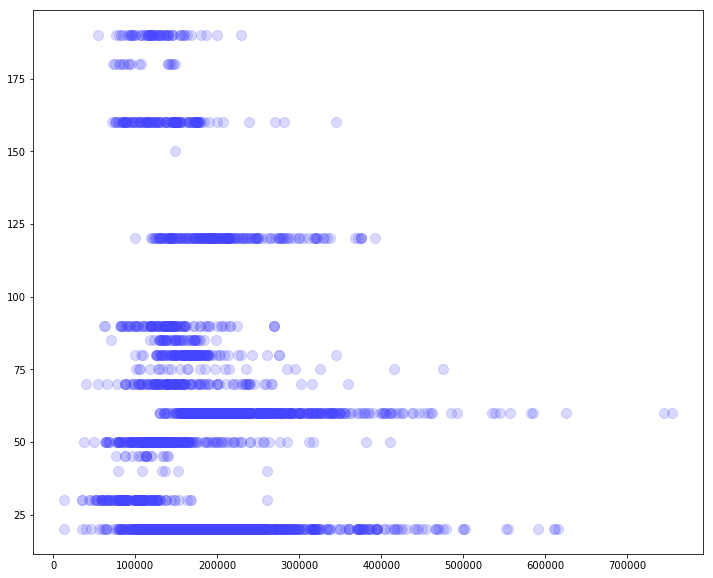

In [18]:
info = raw_data["MS SubClass"]
info2 = raw_data["Half Bath"]
prices = raw_data["SalePrice"]

fig, ax = plt.subplots(figsize=(12,10))
ax.scatter(prices, info, alpha=0.2, s=100, color="#4444FF")
# ax.scatter(prices, info2 + 0.1, alpha=0.2, s=100, color="#44FF44")